## Importation des librairies :

In [41]:
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OrdinalEncoder
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import mlflow
import os
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV 
from imblearn.over_sampling import SMOTE
from joblib import dump
from scipy.stats import randint, uniform

### Importation du fichier : 

In [46]:
# Chargement des données
chemin_dossier = "C:/Users/paulm/Documents/Projet 7/Projet7withCSV/data/" 
df = pd.read_csv(os.path.join(chemin_dossier, 'X_predictionV1.csv'))

#### Premier modèle : 

In [57]:
# Adresse de MLflow
mlflow_url = "http://127.0.0.1:5000"

# Coût d'un faux positif et d'un faux négatif
cost_fp = 1  
cost_fn = 10  

# Conserver la colonne d'identifiant unique
id_column = 'SK_ID_CURR'
df_id = df[[id_column]]  # Conserver les identifiants

# Séparation des caractéristiques (X) et de la cible (y)
X = df.drop(columns=[id_column, 'TARGET']) 
X = X.astype(np.float32)
y = df['TARGET']  

# Séparation des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

# Création du modèle :
class_weight = (len(y_train) - sum(y_train)) / sum(y_train)
model = XGBClassifier(scale_pos_weight=class_weight, random_state=0)
params = {'n_estimators': [100, 200], 'max_depth': [3, 6, 9]}  

# Configurer MLflow
mlflow.set_tracking_uri(mlflow_url)
mlflow.set_experiment("Credit Scoring Experiment")

# Échantillonner les données
sample_size = 0.1
X_train_sample, _, y_train_sample, _ = train_test_split(X_train, y_train, test_size=(1 - sample_size), random_state=0)
X_test_sample, _, y_test_sample, _ = train_test_split(X_test, y_test, test_size=(1 - sample_size), random_state=0)

# Entraînement du modèle XGBoost et obtention des meilleurs paramètres
with mlflow.start_run(run_name="XGBoost"):
    print("Entraînement du modèle XGBoost...")

    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='f1', cv=3)
    grid_search.fit(X_train_sample, y_train_sample)

    # Loguer les paramètres dans MLflow
    mlflow.log_params(grid_search.best_params_)

    # Affichage des meilleurs paramètres et le score F1
    print(f"Meilleurs paramètres pour XGBoost: {grid_search.best_params_}")
    print(f"Score F1 moyen sur le jeu de validation: {grid_search.best_score_:.3f}")

    # Utilisation du meilleur modèle pour les prédictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test_sample)

    # Évaluation du modèle avec le meilleur seuil pour minimiser le coût métier
    y_prob = best_model.predict_proba(X_test_sample)[:, 1]
    thresholds = np.linspace(0, 1, 100)
    costs = []
    for threshold in thresholds:
        y_pred_thresholded = (y_prob > threshold).astype(int)
        fp = np.sum((y_pred_thresholded == 1) & (y_test_sample == 0)) * cost_fp
        fn = np.sum((y_pred_thresholded == 0) & (y_test_sample == 1)) * cost_fn
        total_cost = fp + fn
        costs.append(total_cost)

    best_threshold = thresholds[np.argmin(costs)]
    print(f"Meilleur seuil pour minimiser le coût métier avec XGBoost: {best_threshold}")

    y_pred_best_threshold = (y_prob > best_threshold).astype(int)

    # Affichage du rapport de classification et de la matrice de confusion
    classification_report_str = classification_report(y_test_sample, y_pred_best_threshold)
    confusion_matrix_str = confusion_matrix(y_test_sample, y_pred_best_threshold)

    print(f"Rapport de classification avec le meilleur seuil pour XGBoost:")
    print(classification_report_str)

    print(f"Matrice de confusion avec le meilleur seuil pour XGBoost:")
    print(confusion_matrix_str)
    print()

    # Loguer les métriques et les résultats dans MLflow
    mlflow.log_metric("best_score_f1", grid_search.best_score_)
    mlflow.log_metric("best_threshold", best_threshold)
    mlflow.log_text(classification_report_str, "classification_report.txt")
    mlflow.log_text(str(confusion_matrix_str), "confusion_matrix.txt")

    # Loguer le modèle
    model_path = 'model/xgboost_model.pkl'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    mlflow.sklearn.log_model(best_model, "model")

    # Sauvegarder le modèle dans un fichier .pkl
    joblib.dump(best_model, model_path)

Entraînement du modèle XGBoost...
Meilleurs paramètres pour XGBoost: {'max_depth': 3, 'n_estimators': 100}
Score F1 moyen sur le jeu de validation: 0.262
Meilleur seuil pour minimiser le coût métier avec XGBoost: 0.4747474747474748
Rapport de classification avec le meilleur seuil pour XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.76      0.85      5676
           1       0.18      0.63      0.28       473

    accuracy                           0.75      6149
   macro avg       0.57      0.70      0.57      6149
weighted avg       0.90      0.75      0.81      6149

Matrice de confusion avec le meilleur seuil pour XGBoost:
[[4340 1336]
 [ 176  297]]



### Analyse Globale de l'Importance des Variables pour mon modèle : 

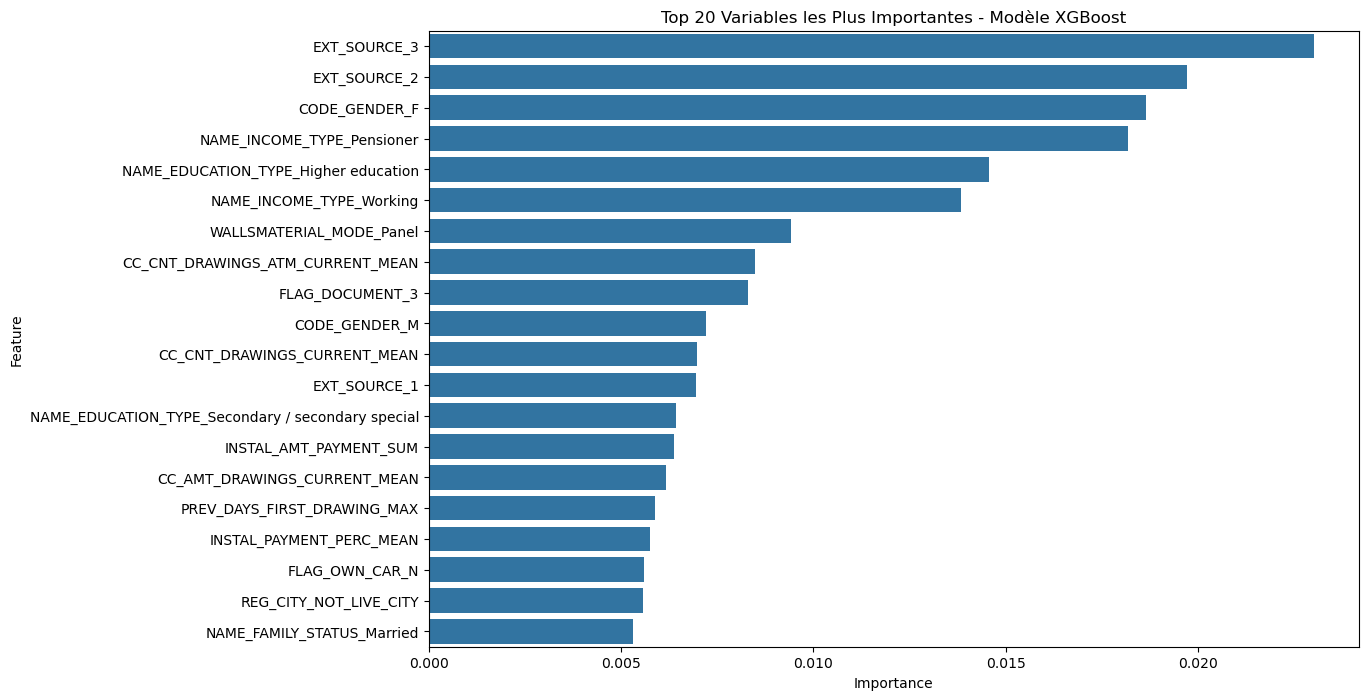

In [48]:
import seaborn as sns

# Entraînement du modèle XGBoost (avec les meilleurs hyperparamètres trouvés)
model = XGBClassifier(scale_pos_weight=class_weight, random_state=0)
model.fit(X_train, y_train)

# Extraire l'importance des variables
importance = model.feature_importances_

# Créer un DataFrame pour faciliter la visualisation
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Sélectionner les 20 variables les plus importantes
top_20_importance_df = importance_df.head(20)

# Visualiser l'importance des variables
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_20_importance_df)
plt.title('Top 20 Variables les Plus Importantes - Modèle XGBoost')
plt.show()

Et maintenant avec une validation croisé plus poussée : 

In [54]:
# Définir la grille de paramètres plus ciblée
params = {
    'n_estimators': [100, 150, 250],
    'max_depth': [3, 6],
    'learning_rate': [0.1, 0.2],
    'subsample': [0.7, 0.8],
    'colsample_bytree': [0.7, 0.8],
    'reg_alpha': [0, 0.01],
    'reg_lambda': [1, 3]
}

# Entraînement du modèle XGBoost avec RandomizedSearchCV
grid_search = RandomizedSearchCV(estimator=model, param_distributions=params, scoring='f1', cv=3, n_iter=30, random_state=42)
grid_search.fit(X_train_sample, y_train_sample)

# Loguer les meilleurs paramètres et score
best_model = grid_search.best_estimator_
print(f"Meilleurs paramètres pour XGBoost: {grid_search.best_params_}")
print(f"Score F1 moyen sur le jeu de validation: {grid_search.best_score_:.3f}")

# Prédictions et évaluation
y_prob = best_model.predict_proba(X_test_sample)[:, 1]
y_pred = best_model.predict(X_test_sample)

# Calcul du meilleur seuil pour minimiser le coût métier
thresholds = np.linspace(0, 1, 100)
costs = []
for threshold in thresholds:
    y_pred_thresholded = (y_prob > threshold).astype(int)
    fp = np.sum((y_pred_thresholded == 1) & (y_test_sample == 0)) * cost_fp
    fn = np.sum((y_pred_thresholded == 0) & (y_test_sample == 1)) * cost_fn
    total_cost = fp + fn
    costs.append(total_cost)

best_threshold = thresholds[np.argmin(costs)]
print(f"Meilleur seuil pour minimiser le coût métier avec XGBoost: {best_threshold}")

y_pred_best_threshold = (y_prob > best_threshold).astype(int)

# Calcul du score AUC-ROC
auc_roc = roc_auc_score(y_test_sample, y_prob)
print(f"AUC-ROC pour le modèle XGBoost: {auc_roc:.3f}")

# Rapport de classification et matrice de confusion
classification_report_str = classification_report(y_test_sample, y_pred_best_threshold)
confusion_matrix_str = confusion_matrix(y_test_sample, y_pred_best_threshold)

print(f"Rapport de classification avec le meilleur seuil pour XGBoost:")
print(classification_report_str)

print(f"Matrice de confusion avec le meilleur seuil pour XGBoost:")
print(confusion_matrix_str)

# Loguer les métriques et le modèle dans MLflow
mlflow.log_metric("best_score_f1", grid_search.best_score_)
mlflow.log_metric("best_threshold", best_threshold)
mlflow.log_metric("auc_roc", auc_roc)
mlflow.log_text(classification_report_str, "classification_report.txt")
mlflow.log_text(str(confusion_matrix_str), "confusion_matrix.txt")

model_path = 'model/xgboost_model_optimized.pkl'
os.makedirs(os.path.dirname(model_path), exist_ok=True)
mlflow.sklearn.log_model(best_model, "model")

# Sauvegarder le modèle dans un fichier .pkl
joblib.dump(best_model, model_path)

Meilleurs paramètres pour XGBoost: {'subsample': 0.7, 'reg_lambda': 3, 'reg_alpha': 0, 'n_estimators': 250, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.7}
Score F1 moyen sur le jeu de validation: 0.101
Meilleur seuil pour minimiser le coût métier avec XGBoost: 0.10101010101010102
AUC-ROC pour le modèle XGBoost: 0.774
Rapport de classification avec le meilleur seuil pour XGBoost:
              precision    recall  f1-score   support

           0       0.96      0.81      0.88      5676
           1       0.21      0.59      0.30       473

    accuracy                           0.79      6149
   macro avg       0.58      0.70      0.59      6149
weighted avg       0.90      0.79      0.83      6149

Matrice de confusion avec le meilleur seuil pour XGBoost:
[[4602 1074]
 [ 196  277]]


['model/xgboost_model_optimized.pkl']

In [56]:
mlflow.end_run()

In [27]:
# Rééquilibrer les classes avec SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Espace d'hyperparamètres pour GridSearchCV
params = {
    'n_estimators': [100, 250],
    'max_depth': [6, 9, 12],
    'learning_rate': [0.01, 0.1, 0.2],
    'scale_pos_weight': [1, scale_pos_weight, scale_pos_weight * 1.5],
    'min_child_weight': [1, 5, 10]
}

# Configurer MLflow
mlflow.set_tracking_uri(mlflow_url)
mlflow.set_experiment("Credit Scoring Experiment")

# Entraînement du modèle XGBoost et optimisation des hyperparamètres
with mlflow.start_run(run_name="XGBoost_with_SMOTE_GridSearch_ROC"):
    print("Entraînement du modèle XGBoost avec SMOTE et GridSearch...")

    model = XGBClassifier(scale_pos_weight=(len(y_train_smote) - sum(y_train_smote)) / sum(y_train_smote), random_state=42)

    # Utilisation de GridSearchCV pour optimiser les hyperparamètres
    grid_search = GridSearchCV(estimator=model, param_grid=params, scoring='roc_auc', cv=3)
    grid_search.fit(X_train_smote, y_train_smote)

    # Loguer les meilleurs paramètres dans MLflow
    mlflow.log_params(grid_search.best_params_)

    # Affichage des meilleurs paramètres et du score F1 moyen
    print(f"Meilleurs paramètres pour XGBoost: {grid_search.best_params_}")
    print(f"Score F1 moyen sur le jeu de validation: {grid_search.best_score_:.3f}")

    # Utilisation du meilleur modèle pour les prédictions
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)

    # Évaluation avec le meilleur seuil pour minimiser le coût métier
    y_prob = best_model.predict_proba(X_test)[:, 1]
    thresholds = np.linspace(0, 1, 100)
    costs = []
    
    for threshold in thresholds:
        y_pred_thresholded = (y_prob > threshold).astype(int)
        fp = np.sum((y_pred_thresholded == 1) & (y_test == 0)) * cost_fp
        fn = np.sum((y_pred_thresholded == 0) & (y_test == 1)) * cost_fn
        total_cost = fp + fn
        costs.append(total_cost)

    best_threshold = thresholds[np.argmin(costs)]
    print(f"Meilleur seuil pour minimiser le coût métier avec XGBoost: {best_threshold}")

    y_pred_best_threshold = (y_prob > best_threshold).astype(int)

    # Calcul du score ROC AUC
    roc_auc = roc_auc_score(y_test, y_prob)
    print(f"Score ROC AUC: {roc_auc:.3f}")

    # Rapport de classification et matrice de confusion
    classification_report_str = classification_report(y_test, y_pred_best_threshold)
    confusion_matrix_str = confusion_matrix(y_test, y_pred_best_threshold)

    print(f"Rapport de classification avec le meilleur seuil pour XGBoost:")
    print(classification_report_str)

    print(f"Matrice de confusion avec le meilleur seuil pour XGBoost:")
    print(confusion_matrix_str)
    print()

    # Loguer les métriques et les résultats dans MLflow
    mlflow.log_metric("best_score_f1", grid_search.best_score_)
    mlflow.log_metric("best_threshold", best_threshold)
    mlflow.log_metric("roc_auc", roc_auc)
    mlflow.log_text(classification_report_str, "classification_report.txt")
    mlflow.log_text(str(confusion_matrix_str), "confusion_matrix.txt")

    # Loguer le modèle
    model_path = 'model/xgboost_model_with_smote.pkl'
    os.makedirs(os.path.dirname(model_path), exist_ok=True)
    mlflow.sklearn.log_model(best_model, "model")

    # Sauvegarder le modèle dans un fichier .pkl
    dump(best_model, model_path) 

Entraînement du modèle XGBoost avec SMOTE et GridSearch...


KeyboardInterrupt: 

In [19]:
# Chargement des données
chemin_dossier_test = "C:/Users/paulm/Documents/Projet 7/Projet7withCSV/data/" 
test = pd.read_csv(os.path.join(chemin_dossier_test, 'X_predictionV0.csv'))

In [20]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307492 entries, 0 to 307491
Columns: 425 entries, SK_ID_CURR to EMERGENCYSTATE_MODE_Yes
dtypes: float64(424), int64(1)
memory usage: 997.0 MB


In [10]:
test.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_NaN,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_NaN,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,-0.57753,0.142123,-0.478080,-0.166127,-0.507449,-0.149458,1.506850,-0.456217,0.379842,...,-0.076284,-1.016924,-0.072889,-0.522979,1.935018,-0.133219,-0.949215,0.963726,-0.087342,1
1,100003,-0.57753,0.426778,1.725439,0.592719,1.600694,-1.252747,-0.166845,-0.460118,1.078694,...,-0.076284,-1.016924,-0.072889,-0.522979,-0.516791,-0.133219,-0.949215,0.963726,-0.087342,0
2,100004,-0.57753,-0.427186,-1.152865,-1.404685,-1.092367,-0.783452,-0.689531,-0.453301,0.206122,...,-0.076284,0.983358,-0.072889,-0.522979,-0.516791,-0.133219,1.053502,-1.037639,-0.087342,0
3,100006,-0.57753,-0.142531,-0.711412,0.177900,-0.653679,-0.928991,-0.680136,-0.473220,-1.375804,...,-0.076284,0.983358,-0.072889,-0.522979,-0.516791,-0.133219,1.053502,-1.037639,-0.087342,0
4,100007,-0.57753,-0.199462,-0.213723,-0.361738,-0.068760,0.563559,-0.892555,-0.473213,0.191646,...,-0.076284,0.983358,-0.072889,-0.522979,-0.516791,-0.133219,1.053502,-1.037639,-0.087342,0


In [11]:
df.head()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_NaN,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_NaN,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,-0.57753,0.142123,-0.478080,-0.166127,-0.507449,-0.149458,1.506850,-0.456217,0.379842,...,-0.076284,-1.016924,-0.072889,-0.522979,1.935018,-0.133219,-0.949215,0.963726,-0.087342,1
1,100003,-0.57753,0.426778,1.725439,0.592719,1.600694,-1.252747,-0.166845,-0.460118,1.078694,...,-0.076284,-1.016924,-0.072889,-0.522979,-0.516791,-0.133219,-0.949215,0.963726,-0.087342,0
2,100004,-0.57753,-0.427186,-1.152865,-1.404685,-1.092367,-0.783452,-0.689531,-0.453301,0.206122,...,-0.076284,0.983358,-0.072889,-0.522979,-0.516791,-0.133219,1.053502,-1.037639,-0.087342,0
3,100006,-0.57753,-0.142531,-0.711412,0.177900,-0.653679,-0.928991,-0.680136,-0.473220,-1.375804,...,-0.076284,0.983358,-0.072889,-0.522979,-0.516791,-0.133219,1.053502,-1.037639,-0.087342,0
4,100007,-0.57753,-0.199462,-0.213723,-0.361738,-0.068760,0.563559,-0.892555,-0.473213,0.191646,...,-0.076284,0.983358,-0.072889,-0.522979,-0.516791,-0.133219,1.053502,-1.037639,-0.087342,0


In [11]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307492 entries, 0 to 307491
Columns: 426 entries, SK_ID_CURR to TARGET
dtypes: float64(424), int64(2)
memory usage: 999.4 MB


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307492 entries, 0 to 307491
Columns: 426 entries, SK_ID_CURR to TARGET
dtypes: float64(424), int64(2)
memory usage: 999.4 MB


In [13]:
df.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_NaN,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_NaN,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,307492.000000,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,...,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,307492.000000
mean,278169.515916,2.278108e-10,-6.916689e-10,-1.715779e-09,-6.006369e-11,-2.892853e-09,-2.737011e-09,-7.488488e-11,3.118813e-09,1.101622e-12,...,-4.163562e-09,1.255545e-08,2.968939e-09,1.603359e-08,-2.311491e-08,-1.443290e-09,-1.413656e-08,3.084308e-09,2.808476e-09,0.080731
std,102783.820231,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.272421
min,100002.000000,-5.775304e-01,-6.036714e-01,-1.376470e+00,-1.758958e+00,-1.348269e+00,-1.487793e+00,-2.106351e+00,-5.784959e-01,-5.587935e+00,...,-7.628357e-02,-1.016924e+00,-7.288873e-02,-5.229786e-01,-5.167911e-01,-1.332191e-01,-9.492149e-01,-1.037639e+00,-8.734234e-02,0.000000
25%,189139.750000,-5.775304e-01,-2.374159e-01,-8.174570e-01,-7.302934e-01,-8.120940e-01,-7.853317e-01,-8.352686e-01,-4.712448e-01,-7.078923e-01,...,-7.628357e-02,-1.016924e+00,-7.288873e-02,-5.229786e-01,-5.167911e-01,-1.332191e-01,-9.492149e-01,-1.037639e+00,-8.734234e-02,0.000000
50%,278192.500000,-5.775304e-01,-9.129329e-02,-2.124032e-01,-1.521547e-01,-2.393616e-01,-1.459154e-01,6.574030e-02,-4.603016e-01,1.368615e-01,...,-7.628357e-02,9.833576e-01,-7.288873e-02,-5.229786e-01,-5.167911e-01,-1.332191e-01,-9.492149e-01,9.637264e-01,-8.734234e-02,0.000000
75%,367125.250000,8.072851e-01,1.421234e-01,5.208211e-01,5.166481e-01,3.821141e-01,5.635589e-01,8.304063e-01,-4.537542e-01,8.447970e-01,...,-7.628357e-02,9.833576e-01,-7.288873e-02,-5.229786e-01,-5.167911e-01,-1.332191e-01,1.053502e+00,9.637264e-01,-8.734234e-02,0.000000
max,456235.000000,2.573397e+01,4.926894e+02,8.573968e+00,1.593296e+01,9.509276e+00,3.733528e+00,1.958730e+00,2.133608e+00,1.415346e+00,...,1.310898e+01,9.833576e-01,1.371954e+01,1.912124e+00,1.935018e+00,7.506432e+00,1.053502e+00,9.637264e-01,1.144920e+01,1.000000


In [19]:
test.describe()

,SK_ID_CURR,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,...,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_NaN,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_NaN,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
count,307492.000000,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,...,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,3.074920e+05,307492.000000
mean,278169.515916,2.278108e-10,-6.916689e-10,-1.715779e-09,-6.006369e-11,-2.892853e-09,-2.737011e-09,-7.488488e-11,3.118813e-09,1.101622e-12,...,-4.163562e-09,1.255545e-08,2.968939e-09,1.603359e-08,-2.311491e-08,-1.443290e-09,-1.413656e-08,3.084308e-09,2.808476e-09,0.080731
std,102783.820231,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,...,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,1.000002e+00,0.272421
min,100002.000000,-5.775304e-01,-6.036714e-01,-1.376470e+00,-1.758958e+00,-1.348269e+00,-1.487793e+00,-2.106351e+00,-5.784959e-01,-5.587935e+00,...,-7.628357e-02,-1.016924e+00,-7.288873e-02,-5.229786e-01,-5.167911e-01,-1.332191e-01,-9.492149e-01,-1.037639e+00,-8.734234e-02,0.000000
25%,189139.750000,-5.775304e-01,-2.374159e-01,-8.174570e-01,-7.302934e-01,-8.120940e-01,-7.853317e-01,-8.352686e-01,-4.712448e-01,-7.078923e-01,...,-7.628357e-02,-1.016924e+00,-7.288873e-02,-5.229786e-01,-5.167911e-01,-1.332191e-01,-9.492149e-01,-1.037639e+00,-8.734234e-02,0.000000
50%,278192.500000,-5.775304e-01,-9.129329e-02,-2.124032e-01,-1.521547e-01,-2.393616e-01,-1.459154e-01,6.574030e-02,-4.603016e-01,1.368615e-01,...,-7.628357e-02,9.833576e-01,-7.288873e-02,-5.229786e-01,-5.167911e-01,-1.332191e-01,-9.492149e-01,9.637264e-01,-8.734234e-02,0.000000
75%,367125.250000,8.072851e-01,1.421234e-01,5.208211e-01,5.166481e-01,3.821141e-01,5.635589e-01,8.304063e-01,-4.537542e-01,8.447970e-01,...,-7.628357e-02,9.833576e-01,-7.288873e-02,-5.229786e-01,-5.167911e-01,-1.332191e-01,1.053502e+00,9.637264e-01,-8.734234e-02,0.000000
max,456235.000000,2.573397e+01,4.926894e+02,8.573968e+00,1.593296e+01,9.509276e+00,3.733528e+00,1.958730e+00,2.133608e+00,1.415346e+00,...,1.310898e+01,9.833576e-01,1.371954e+01,1.912124e+00,1.935018e+00,7.506432e+00,1.053502e+00,9.637264e-01,1.144920e+01,1.000000
